# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows' , 10000)

## 1. Data Cleaning

In [2]:
df = pd.read_csv('student_data.csv')

In [3]:
df.shape

(23999, 25)

In [4]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2873,350000,1,1,2,37,-2,-2,-2,-2,-2,-2,316,316,316,466,466,316,316,316,466,466,316,316,0
1,3598,50000,2,2,1,37,2,2,2,0,0,0,40994,43594,38222,13026,13268,13497,5500,0,580,600,600,600,0
2,27623,50000,2,1,2,23,-1,-1,-1,-1,-1,-1,3430,2478,2299,4800,9810,660,2548,2321,4800,9810,660,2980,0
3,6874,20000,1,3,1,56,0,0,0,0,2,0,10847,12176,12884,13784,13420,13686,1508,1216,1116,0,490,658,0
4,6444,110000,2,2,2,32,0,0,0,0,0,0,108159,106812,108464,108829,110557,106082,5400,5400,4100,4100,4100,4200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,7886,50000,2,1,2,24,0,0,0,-2,-2,-2,12806,13490,0,0,0,0,7522,0,0,0,0,0,1
23995,7750,250000,1,3,1,44,-1,-1,-1,-1,-1,-1,6826,3900,4482,43546,38051,576,3924,4482,43676,38166,576,2389,1
23996,14379,50000,1,3,2,26,2,0,0,2,2,2,41827,42650,45930,44891,47654,48721,1800,4000,0,3500,2000,0,1
23997,23664,110000,2,2,1,38,0,0,0,0,0,0,195437,176420,63142,39854,9293,-1288,5000,10000,5048,2000,39958,52000,1


In [5]:
def increasing_debt(row, column, i):
    if i > 1 and row[column+f'{i}'] < row[column+f'{i-1}'] and row["is_streak"] == 1:
        row["debt_streak"] += 1
        row["raw_debt_accum"] += row[column+f'{i-1}'] - row[column+f'{i}']
    else:
        row["is_streak"] = 0
    return row
def initiate_placeholders(df):
    df["is_streak"], df["debt_streak"] = 1, 0
    df["raw_debt_accum"] = 0
    return df
    
def remove_placeholders(df):
    return df.drop(columns=["is_streak", "raw_debt_accum"])
#Gathers column names to exclude
def exclude_columns(looped_cols):
    looped_exc = []
    for col in looped_cols:
        sing_exc = [col+f"{i}" for i in np.arange(1,7)]
        looped_exc.extend(sing_exc)
    return looped_exc
def calculate_utilization(df):
    df["avg_utilization"] = 0
    initiate_placeholders(df)
    for i in np.arange(1,7):
        df['payment_impact'+f'{i}']=(df['PAY_AMT'+f'{i}'])/df["LIMIT_BAL"]
        df["utilization"+f'{i}'] = df["BILL_AMT"+f'{i}']/df["LIMIT_BAL"]
        if i > 1:
            df = df.apply(lambda x: increasing_debt(x, "utilization", i), axis=1)
        df["avg_utilization"] += df["utilization"+f'{i}']
    df["avg_utilization"] = df["avg_utilization"]/6
    df["debt_avg_delta"] = (df["raw_debt_accum"]/df["debt_streak"]).fillna(0)
    df = remove_placeholders(df)
    return df
        
df=calculate_utilization(df)
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,avg_utilization,debt_streak,payment_impact1,utilization1,payment_impact2,utilization2,payment_impact3,utilization3,payment_impact4,utilization4,payment_impact5,utilization5,payment_impact6,utilization6,debt_avg_delta
0,2873.0,350000.0,1.0,1.0,2.0,37.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,0.0,0.001046,0.0,0.000903,0.000903,0.000903,0.000903,0.001331,0.000903,0.001331,0.001331,0.000903,0.001331,0.000903,0.000903,0.000000
1,3598.0,50000.0,2.0,2.0,1.0,37.0,2.0,2.0,2.0,0.0,0.0,0.0,40994.0,43594.0,38222.0,13026.0,13268.0,13497.0,5500.0,0.0,580.0,600.0,600.0,600.0,0.0,0.542003,0.0,0.110000,0.819880,0.000000,0.871880,0.011600,0.764440,0.012000,0.260520,0.012000,0.265360,0.012000,0.269940,0.000000
2,27623.0,50000.0,2.0,1.0,2.0,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3430.0,2478.0,2299.0,4800.0,9810.0,660.0,2548.0,2321.0,4800.0,9810.0,660.0,2980.0,0.0,0.078257,2.0,0.050960,0.068600,0.046420,0.049560,0.096000,0.045980,0.196200,0.096000,0.013200,0.196200,0.059600,0.013200,0.011310
3,6874.0,20000.0,1.0,3.0,1.0,56.0,0.0,0.0,0.0,0.0,2.0,0.0,10847.0,12176.0,12884.0,13784.0,13420.0,13686.0,1508.0,1216.0,1116.0,0.0,490.0,658.0,0.0,0.639975,0.0,0.075400,0.542350,0.060800,0.608800,0.055800,0.644200,0.000000,0.689200,0.024500,0.671000,0.032900,0.684300,0.000000
4,6444.0,110000.0,2.0,2.0,2.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,108159.0,106812.0,108464.0,108829.0,110557.0,106082.0,5400.0,5400.0,4100.0,4100.0,4100.0,4200.0,0.0,0.983186,1.0,0.049091,0.983264,0.049091,0.971018,0.037273,0.986036,0.037273,0.989355,0.037273,1.005064,0.038182,0.964382,0.012245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,7886.0,50000.0,2.0,1.0,2.0,24.0,0.0,0.0,0.0,-2.0,-2.0,-2.0,12806.0,13490.0,0.0,0.0,0.0,0.0,7522.0,0.0,0.0,0.0,0.0,0.0,1.0,0.087653,0.0,0.150440,0.256120,0.000000,0.269800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23995,7750.0,250000.0,1.0,3.0,1.0,44.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6826.0,3900.0,4482.0,43546.0,38051.0,576.0,3924.0,4482.0,43676.0,38166.0,576.0,2389.0,1.0,0.064921,1.0,0.015696,0.027304,0.017928,0.015600,0.174704,0.017928,0.152664,0.174184,0.002304,0.152204,0.009556,0.002304,0.011704
23996,14379.0,50000.0,1.0,3.0,2.0,26.0,2.0,0.0,0.0,2.0,2.0,2.0,41827.0,42650.0,45930.0,44891.0,47654.0,48721.0,1800.0,4000.0,0.0,3500.0,2000.0,0.0,1.0,0.905577,0.0,0.036000,0.836540,0.080000,0.853000,0.000000,0.918600,0.070000,0.897820,0.040000,0.953080,0.000000,0.974420,0.000000
23997,23664.0,110000.0,2.0,2.0,1.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,195437.0,176420.0,63142.0,39854.0,9293.0,-1288.0,5000.0,10000.0,5048.0,2000.0,39958.0,52000.0,1.0,0.731603,5.0,0.045455,1.776700,0.090909,1.603818,0.045891,0.574018,0.018182,0.362309,0.363255,0.084482,0.472727,-0.011709,0.357682


In [6]:
excluded = exclude_columns(["PAY_AMT", "BILL_AMT"])
selection = df.drop(columns = excluded).columns
selection

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'default payment next month', 'avg_utilization', 'debt_streak',
       'payment_impact1', 'utilization1', 'payment_impact2', 'utilization2',
       'payment_impact3', 'utilization3', 'payment_impact4', 'utilization4',
       'payment_impact5', 'utilization5', 'payment_impact6', 'utilization6',
       'debt_avg_delta'],
      dtype='object')

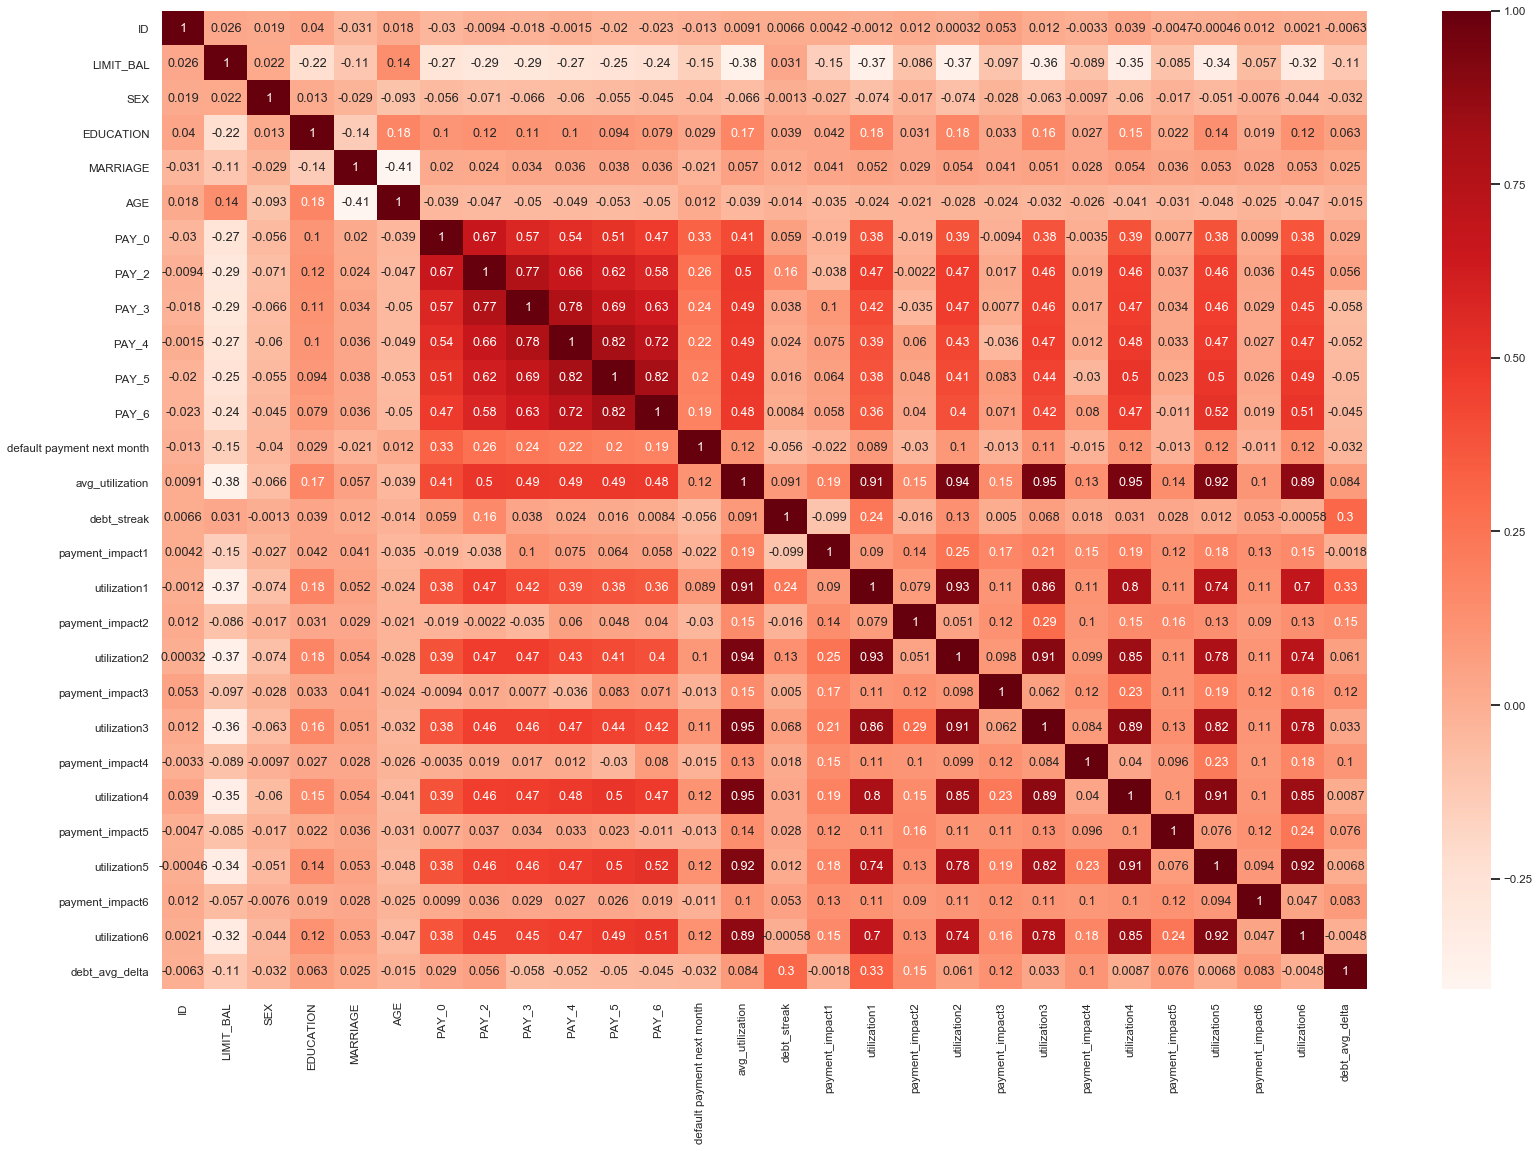

In [7]:
sns.set(rc = {'figure.figsize':(27,18)})
sns.set_context('talk' , font_scale=0.7)

sns.heatmap(df[selection].corr(),cmap='Reds' , annot=True)

In [8]:
# sns.set(rc = {'figure.figsize':(27,18)})
# sns.set_context('talk' , font_scale=0.7)

# sns.heatmap(df.iloc[:,1:].corr(),cmap='Reds' , annot=True)

## 2. EDA

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,23999.0,15027.353931,8654.746941,1.000000,7506.000000,15027.000000,22531.500000,3.000000e+04
LIMIT_BAL,23999.0,167825.729405,129915.115993,10000.000000,50000.000000,140000.000000,240000.000000,1.000000e+06
SEX,23999.0,1.603608,0.489158,1.000000,1.000000,2.000000,2.000000,2.000000e+00
EDUCATION,23999.0,1.856786,0.791939,0.000000,1.000000,2.000000,2.000000,6.000000e+00
MARRIAGE,23999.0,1.550773,0.522431,0.000000,1.000000,2.000000,2.000000,3.000000e+00
AGE,23999.0,35.523230,9.253986,21.000000,28.000000,34.000000,42.000000,7.900000e+01
PAY_0,23999.0,-0.014959,1.120903,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_2,23999.0,-0.134839,1.193044,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_3,23999.0,-0.165632,1.193515,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_4,23999.0,-0.217092,1.168719,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00


In [ ]:
# default中1的占比为22%。即下个月将有22%的客户违约；信用卡限额limit_bal的平均值为167484.322667；客户的平均年龄35，最大年龄为79；教育水平主要为研究生和本科。绝大多数客户要么结婚要么单身。对于Pay_1~ Pay_6，至少75%的客户不处于付款延迟状态。

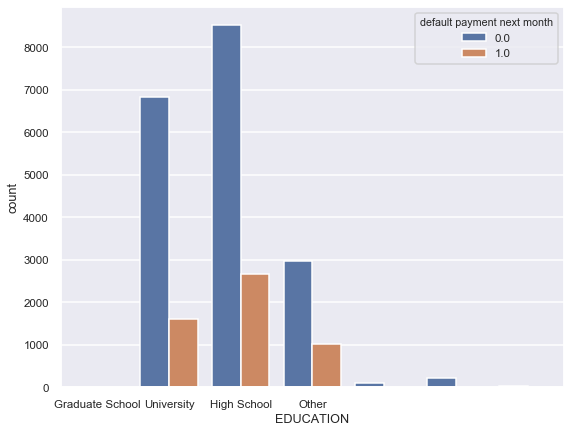

In [13]:
sns.set(rc = {'figure.figsize':(9,7)})
sns.set_context('talk' , font_scale=0.7)

edu = sns.countplot(x = 'EDUCATION'  ,hue='default payment next month', data = df)
edu.set_xticklabels(['Graduate School' , 'University' , 'High School' , 'Other'])
plt.show()

In [22]:
default0 = df.groupby(df['EDUCATION'][df['default payment next month']==0]).size().reset_index(name = "NOT_DEFAULT")
default1 = df.groupby(df['EDUCATION'][df['default payment next month']==1]).size().reset_index(name = "DEFAULT")
total = df.groupby(df['EDUCATION']).size().reset_index(name = "Total")

eduTable = default0.join(default1['DEFAULT']).join(total['Total'])
eduTable

,EDUCATION,NOT_DEFAULT,DEFAULT,Total
0,0.0,11,1616.0,11
1,1.0,6826,2656.0,8442
2,2.0,8532,1012.0,11188
3,3.0,2982,5.0,3994
4,4.0,95,14.0,100
5,5.0,209,5.0,223
6,6.0,36,NaN,41


## 3. Feature Engineering

## 4. Feature Selection

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

## 6. Model Evaluation

## 7. Final Model